In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import json
import pandas as pd

file_path = "/content/user-wallet-transactions.json"

with open(file_path, 'r') as f:
    data = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(data)
df.head()


,_id,userWallet,network,protocol,txHash,logId,timestamp,blockNumber,action,actionData,__v,createdAt,updatedAt
0,{'$oid': '681d38fed63812d4655f571a'},0x00000000001accfa9cef68cf5371a23025b6d4b6,polygon,aave_v2,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,1629178166,1629178166,deposit,"{'type': 'Deposit', 'amount': '2000000000', 'a...",0,{'$date': '2025-05-08T23:06:39.465Z'},{'$date': '2025-05-08T23:06:39.465Z'}
1,{'$oid': '681aa70dd6df53021cc6f3c0'},0x000000000051d07a4fb3bd10121a343d85818da6,polygon,aave_v2,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,1621525013,1621525013,deposit,"{'type': 'Deposit', 'amount': '145000000000000...",0,{'$date': '2025-05-07T00:19:26.159Z'},{'$date': '2025-05-07T00:19:26.159Z'}
2,{'$oid': '681d04c2d63812d4654c733e'},0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,1627118913,1627118913,deposit,"{'type': 'Deposit', 'amount': '100000000000000...",0,{'$date': '2025-05-08T19:23:47.877Z'},{'$date': '2025-05-08T19:23:47.877Z'}
3,{'$oid': '681d133bd63812d46551b6ef'},0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,1627773318,1627773318,deposit,"{'type': 'Deposit', 'amount': '400000000000000...",0,{'$date': '2025-05-08T20:25:33.141Z'},{'$date': '2025-05-08T20:25:33.141Z'}
4,{'$oid': '681899e4ba49fc91cf2f4454'},0x0000000000e189dd664b9ab08a33c4839953852c,polygon,aave_v2,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,1618845907,1618845907,redeemunderlying,"{'type': 'RedeemUnderlying', 'amount': '501548...",0,{'$date': '2025-05-05T10:58:45.934Z'},{'$date': '2025-05-05T10:58:45.934Z'}


In [14]:
df.shape


(100000, 15)

Extract amount from actionData

In [4]:
# Extract 'amount' as float
df['amount'] = df['actionData'].apply(lambda x: float(x.get('amount', 0)) if isinstance(x, dict) else 0)

# Confirm extraction
df[['userWallet', 'action', 'amount']].head()


,userWallet,action,amount
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,deposit,2.000000e+09
1,0x000000000051d07a4fb3bd10121a343d85818da6,deposit,1.450000e+20
2,0x000000000096026fb41fc39f9875d164bd82e2dc,deposit,1.000000e+15
3,0x000000000096026fb41fc39f9875d164bd82e2dc,deposit,4.000000e+15
4,0x0000000000e189dd664b9ab08a33c4839953852c,redeemunderlying,5.015480e+05


Converting  timestamp to readable date

In [5]:
from datetime import datetime

df['datetime'] = df['timestamp'].apply(lambda x: datetime.fromtimestamp(x))


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   _id          100000 non-null  object        
 1   userWallet   100000 non-null  object        
 2   network      100000 non-null  object        
 3   protocol     100000 non-null  object        
 4   txHash       100000 non-null  object        
 5   logId        100000 non-null  object        
 6   timestamp    100000 non-null  int64         
 7   blockNumber  100000 non-null  int64         
 8   action       100000 non-null  object        
 9   actionData   100000 non-null  object        
 10  __v          100000 non-null  int64         
 11  createdAt    100000 non-null  object        
 12  updatedAt    100000 non-null  object        
 13  amount       100000 non-null  float64       
 14  datetime     100000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), i

Group By Wallet to Engineer Features

In [8]:
wallet_df = df.groupby('userWallet').agg(
    total_tx=('action', 'count'),
    total_amount=('amount', 'sum'),
    deposits=('action', lambda x: (x == 'deposit').sum()),
    borrows=('action', lambda x: (x == 'borrow').sum()),
    repays=('action', lambda x: (x == 'repay').sum()),
    liquidations=('action', lambda x: (x == 'liquidationcall').sum()),
    redeems=('action', lambda x: (x == 'redeemunderlying').sum()),
).reset_index()

wallet_df.head()


,userWallet,total_tx,total_amount,deposits,borrows,repays,liquidations,redeems
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1,2.000000e+09,1,0,0,0,0
1,0x000000000051d07a4fb3bd10121a343d85818da6,1,1.450000e+20,1,0,0,0,0
2,0x000000000096026fb41fc39f9875d164bd82e2dc,2,5.000000e+15,2,0,0,0,0
3,0x0000000000e189dd664b9ab08a33c4839953852c,17,4.835297e+18,0,0,0,0,17
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,399,1.735192e+23,250,15,4,0,130


Created Advanced Wallet-Level Features

In [9]:
# Avoid division by zero with small constant
epsilon = 1e-6

wallet_df['repay_ratio'] = wallet_df['repays'] / (wallet_df['borrows'] + epsilon)
wallet_df['borrow_deposit_ratio'] = wallet_df['borrows'] / (wallet_df['deposits'] + epsilon)
wallet_df['liquidation_flag'] = wallet_df['liquidations'].apply(lambda x: 1 if x > 0 else 0)
wallet_df['redeem_ratio'] = wallet_df['redeems'] / (wallet_df['deposits'] + epsilon)
wallet_df['activity_score'] = wallet_df['total_tx']  # basic proxy for wallet activeness


We now build a simple rule-based formula using these features.

Define a Weighted Scoring Logic

In [15]:
import numpy as np

# Fix repay_ratio to max of 1
wallet_df['repay_ratio'] = wallet_df['repay_ratio'].clip(upper=1)

# Log scale activity (optional)
wallet_df['log_activity'] = np.log1p(wallet_df['activity_score'])

# New balanced formula
wallet_df['raw_score'] = (
    wallet_df['repay_ratio'] * 400 +
    (1 - wallet_df['borrow_deposit_ratio'].clip(0, 1)) * 200 +
    (1 - wallet_df['liquidation_flag']) * 200 +
    wallet_df['redeem_ratio'].clip(0, 1) * 100 +
    wallet_df['log_activity'] * 20  # log-scaled
)

# Scale to 0–1000
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1000))
wallet_df['score'] = scaler.fit_transform(wallet_df[['raw_score']])



In [16]:
wallet_df['score_band'] = pd.cut(wallet_df['score'], bins=[0,100,200,300,400,500,600,700,800,900,1000])
wallet_df['score_band'].value_counts().sort_index()


,count
score_band,
"(0, 100]",11
"(100, 200]",16
"(200, 300]",232
"(300, 400]",166
"(400, 500]",1636
"(500, 600]",512
"(600, 700]",202
"(700, 800]",321
"(800, 900]",269


In [18]:
df['userWallet'].nunique()


3497

To Find Those 4 Wallets with Missing Scores

In [21]:
wallet_df[wallet_df['score_band'].isna()]


,userWallet,total_tx,total_amount,deposits,borrows,repays,liquidations,redeems,repay_ratio,borrow_deposit_ratio,liquidation_flag,redeem_ratio,activity_score,raw_score,score,score_band,log_activity
396,0x0092a80c90069d5a243caa28fff0eddd5c03696d,3,1.000000e+18,1,1,0,1,0,0.0,0.999999,1,0.0,3,27.726087,0.0,NaN,1.386294
419,0x009b56330ae5ec5042b9ca46ddb3043cc0d006f3,3,1.001000e+20,1,1,0,1,0,0.0,0.999999,1,0.0,3,27.726087,0.0,NaN,1.386294
2312,0x03f90f638fc2c73e43008e66e11e554a8de746ae,3,1.415898e+20,1,1,0,1,0,0.0,0.999999,1,0.0,3,27.726087,0.0,NaN,1.386294
2962,0x052a44f7e4213413b9b9440ded0175a3b43bffc1,3,7.363693e+19,1,1,0,1,0,0.0,0.999999,1,0.0,3,27.726087,0.0,NaN,1.386294


In [22]:
wallet_df['score_band'] = pd.cut(
    wallet_df['score'],
    bins=[0,100,200,300,400,500,600,700,800,900,1000],
    include_lowest=True
)


In [26]:
wallet_df['score_band'].value_counts().sort_index()


,count
score_band,
"(-0.001, 100.0]",15
"(100.0, 200.0]",16
"(200.0, 300.0]",232
"(300.0, 400.0]",166
"(400.0, 500.0]",1636
"(500.0, 600.0]",512
"(600.0, 700.0]",202
"(700.0, 800.0]",321
"(800.0, 900.0]",269


Visualize Score Distribution

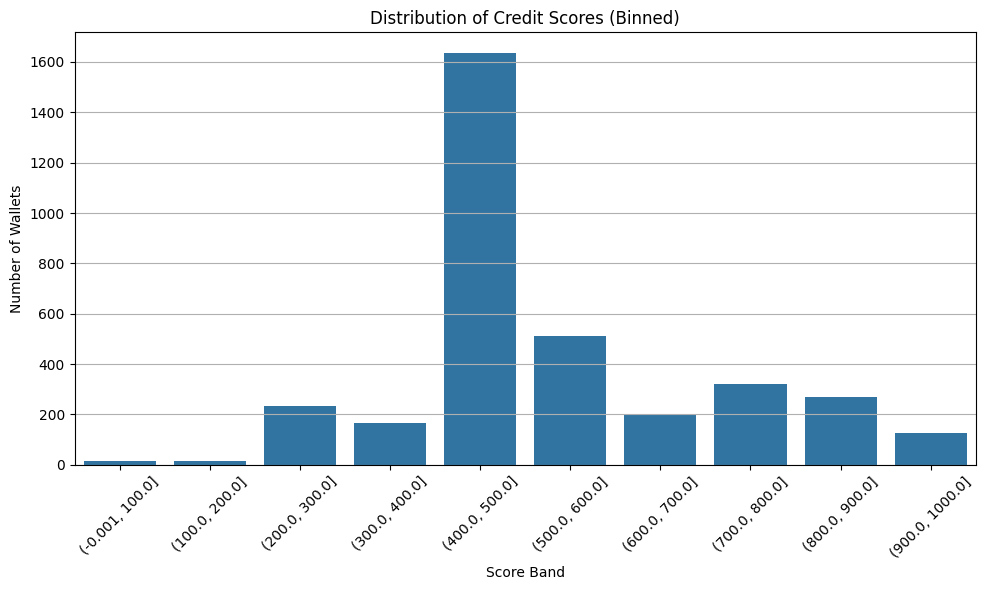

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.countplot(data=wallet_df, x='score_band', order=wallet_df['score_band'].value_counts().sort_index().index)
plt.title('Distribution of Credit Scores (Binned)')
plt.xlabel('Score Band')
plt.ylabel('Number of Wallets')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
